In [1]:
import bats
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import persim
import plotly.express as px
import plotly.graph_objects as go
import ripser
import tqdm
from itertools import combinations
from natsort import natsorted
from persim import PersistenceImager
from scipy.spatial import distance_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
START = 25
END = 35
STEP = 1

params = pd.read_csv('data/params_file.csv')
labels = params.end_has_niche

In [4]:
i0 = params[params.id == 183].index[0]
i1 = params[params.id == 755].index[0]
i2 = params[params.id == 1189].index[0]

labels[i0], labels[i1], labels[i2]

(False, False, True)

In [5]:
def zigzag_dgms(Id, celltype, MU=1):
    MPs = []
    files = natsorted(glob.glob(f'data/ID-{Id}_time-*_From*ParamSweep_Data.csv'))[START:END:STEP]
    for f in files:
        df = pd.read_csv(f)
        mp = df[df.celltypes == celltype][['points_x', 'points_y']].to_numpy()
        MPs.append( mp )

    Dgm = bats.SimplicialComplexDiagram(2*len(MPs)-1, 2*len(MPs)-2)

    for t in range(len(MPs)):
        MP = MPs[t]
        D = distance_matrix(MP, MP)
        X = bats.SimplicialComplex()
        for nb_edges in [1, 2]:
            for simplex_ in combinations(range(len(MP)), nb_edges):
                if all(
                    D[i, j] <= MU
                    for edge in combinations(simplex_, 2)
                    for (i, j) in [ tuple(edge) ]
                ):
                    X.add(list(simplex_))
        Dgm.set_node(2*t, X)

    for t in range(1, len(MPs)):
        I = bats.SimplicialComplex()

        n = min( len(MPs[t-1]), len(MPs[t]) )
        D_A = distance_matrix(MPs[t-1], MPs[t-1])
        D_B = distance_matrix(MPs[t], MPs[t])
        for nb_edges in [1, 2]:
            for simplex_ in combinations(range(n), nb_edges):
                in_A = all(
                    D_A[i, j] <= MU
                    for edge in combinations(simplex_, 2)
                    for (i, j) in [ tuple(edge) ]
                )
                in_B = all(
                    D_B[i, j] <= MU
                    for edge in combinations(simplex_, 2)
                    for (i, j) in [ tuple(edge) ]
                )
                if in_A and in_B:
                    I.add(list(simplex_))

        Dgm.set_node(2*t-1, I)
        Dgm.set_edge(
            2*t-2,
            2*t-1, 2*t-2,
            bats.SimplicialMap(
                I, 
                Dgm.node_data(2*t-2),
                list(range(n)),
            ),
        )
        Dgm.set_edge(
            2*t-1,
            2*t-1, 2*t,
            bats.SimplicialMap(
                I, 
                Dgm.node_data(2*t),
                list(range(n)),
            ),
        )

    CD = bats.Chain(Dgm, bats.F2())
    HD0 = bats.Hom(CD, 0)
    ps0 = bats.barcode(HD0, 0)    
    ls_bars0 = np.array([
        [b, d] for p in ps0 for b in [p.birth()] for d in [p.death()] #if b != d
    ]).reshape(-1, 2)
    
    return ls_bars0


In [6]:
def rips_dgms(Id, celltype):
    files = natsorted(glob.glob(f'data/ID-{Id}_time-*_From*ParamSweep_Data.csv'))[START:END:STEP]

    bars = []
    for i,f in enumerate(files):
        df = pd.read_csv(f)
        mp = df[df.celltypes == celltype][['points_x', 'points_y']].to_numpy()
        if mp.size == 0: 
            continue
        else:
            dgms = ripser.ripser(mp, distance_matrix=False, maxdim=0)['dgms'][0]
            bars.extend( 
                dgms[dgms[:,1] != np.inf] 
                + [i, 0] 
            )

    return np.array(bars)


In [7]:
def cell_count(Id, celltype):
    files = natsorted(glob.glob(f'data/ID-{Id}_time-*_From*ParamSweep_Data.csv'))[START:END:STEP]

    counts = []
    for i,f in enumerate(files):
        df = pd.read_csv(f)
        mp = df[df.celltypes == celltype]
        counts.append( len(mp) )

    return counts


In [8]:
def cell_count_close(Id, celltype, r=2):
    files = natsorted(glob.glob(f'data/ID-{Id}_time-*_From*ParamSweep_Data.csv'))[START:END:STEP]
    assert len(files) > 0, f"{Id}"
    ds = []
    for i,f in enumerate(files):
        df = pd.read_csv(f)
        tum = df[df.celltypes == celltype][['points_x', 'points_y']].to_numpy()
        ves = df[df.celltypes == 'Vessel'][['points_x', 'points_y']].to_numpy()
        D = distance_matrix(tum, ves)
        if D.size == 0:
            ds.append( 0 )
        else:
            D[D == 0] = np.inf
            d = D.min(axis=1)
            ds.append( len(d[d <= r]) )
    return ds


In [9]:
def vessel_proximity(Id, celltype):
    files = natsorted(glob.glob(f'data/ID-{Id}_time-*_From*ParamSweep_Data.csv'))[START:END:STEP]
    assert len(files) > 0, f"{Id}"
    ds = []
    for i,f in enumerate(files):
        df = pd.read_csv(f)
        tum = df[df.celltypes == celltype][['points_x', 'points_y']].to_numpy()
        ves = df[df.celltypes == 'Vessel'][['points_x', 'points_y']].to_numpy()
        D = distance_matrix(tum, ves)
        ds.append( np.sqrt(2)*50 if D.size == 0 else distance_matrix(tum, ves).min() )

    return ds


In [28]:
def phenotype_ratio(Id):
    files = natsorted(glob.glob(f'data/ID-{Id}_time-*_From*ParamSweep_Data.csv'))[START:END:STEP]
    assert len(files) > 0, f"{Id}"
    rs = []
    for i,f in enumerate(files):
        df = pd.read_csv(f)
        p = df[df.celltypes == 'Macrophage'].phenotypes
        rs.append( 0 if p.size == 0 else len(p[p < .5]) / len(p) )

    return rs


In [11]:
imgs = {}
scores = {}

100%|███████████████████████████████████████| 1485/1485 [23:20<00:00,  1.06it/s]


0.6080808080808081


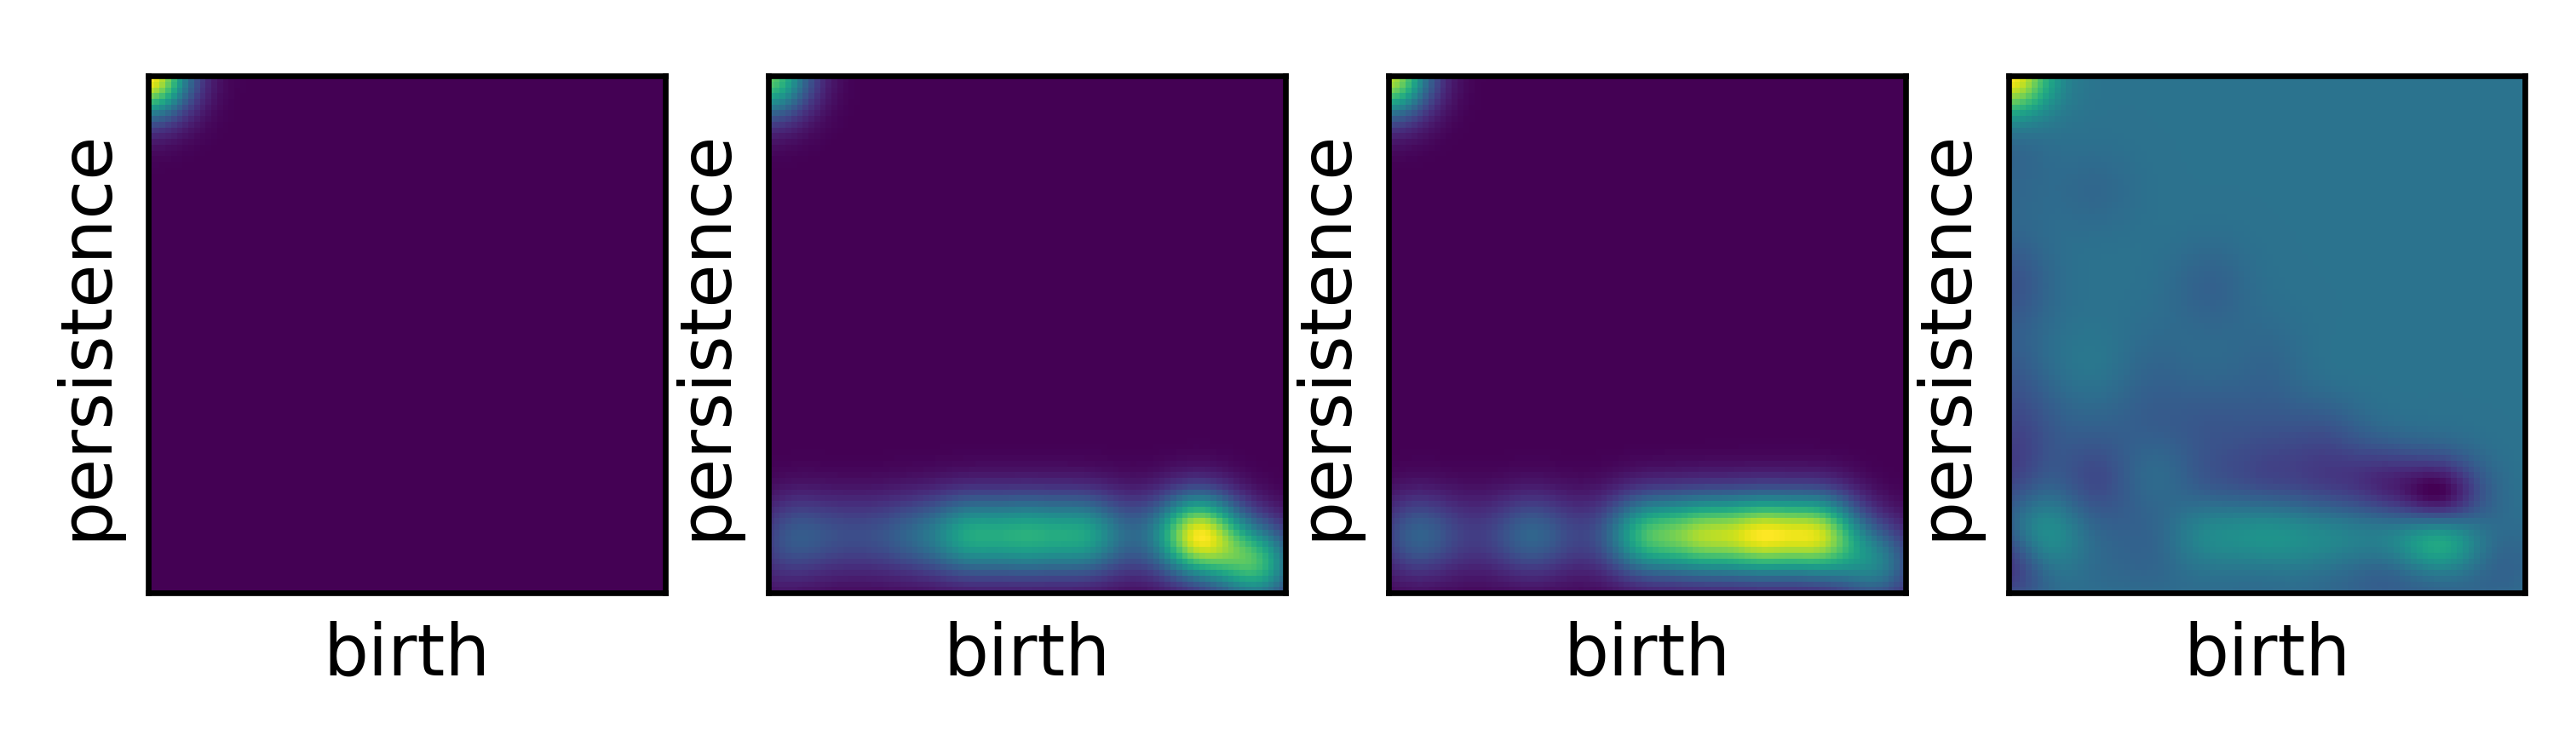

array([0.6026936 , 0.60606061, 0.6026936 , 0.60942761, 0.6026936 ,
       0.5959596 , 0.61279461, 0.6026936 , 0.61279461, 0.62289562,
       0.6026936 , 0.61616162, 0.6026936 , 0.60606061, 0.60942761,
       0.5993266 , 0.6026936 , 0.61616162, 0.60606061, 0.60606061,
       0.6026936 , 0.61616162, 0.60606061, 0.59259259, 0.5993266 ,
       0.6026936 , 0.6026936 , 0.5993266 , 0.60606061, 0.5959596 ,
       0.6026936 , 0.60942761, 0.60942761, 0.60606061, 0.61279461,
       0.60942761, 0.61616162, 0.5993266 , 0.61616162, 0.61616162,
       0.5959596 , 0.61616162, 0.5993266 , 0.60606061, 0.6026936 ,
       0.60606061, 0.60942761, 0.5993266 , 0.60942761, 0.5993266 ])

In [12]:
diagrams_h0_zzt = []
empty_idx = []
for i, ID in enumerate(tqdm.tqdm(params.id)):
    dgms = zigzag_dgms(ID, 'Tumour', MU=1)
    if dgms.size == 0: 
        empty_idx.append(i)
        dgms = np.array([ [0,1], [1,2] ])
    diagrams_h0_zzt.append( dgms )
    
pimgr_zzt = PersistenceImager()
imgs_zzt = pimgr_zzt.fit_transform(diagrams_h0_zzt)
imgs_array_zzt = np.array([
    img.flatten()
    for img in imgs_zzt
])
for i in empty_idx:
    imgs_array_zzt[i] = np.zeros(pimgr_zzt.resolution).flatten()
imgs['zzt'] = imgs_zzt

clf = LogisticRegression(max_iter=1000)
clf.fit(imgs_array_zzt, labels)
print(clf.score(imgs_array_zzt, labels))
inverse_image = np.copy(clf.coef_).reshape(pimgr_zzt.resolution)

fig = plt.figure(dpi=600)
pimgr_zzt.plot_image(imgs_zzt[i0], fig.add_subplot(141))
pimgr_zzt.plot_image(imgs_zzt[i1], fig.add_subplot(142))
pimgr_zzt.plot_image(imgs_zzt[i2], fig.add_subplot(143))
pimgr_zzt.plot_image(inverse_image, fig.add_subplot(144))
plt.show()

cv = RepeatedStratifiedKFold()
scores['zzt'] = cross_val_score(clf, imgs_array_zzt, labels, cv=cv)
scores['zzt']

100%|███████████████████████████████████████| 1485/1485 [03:24<00:00,  7.25it/s]


0.8787878787878788


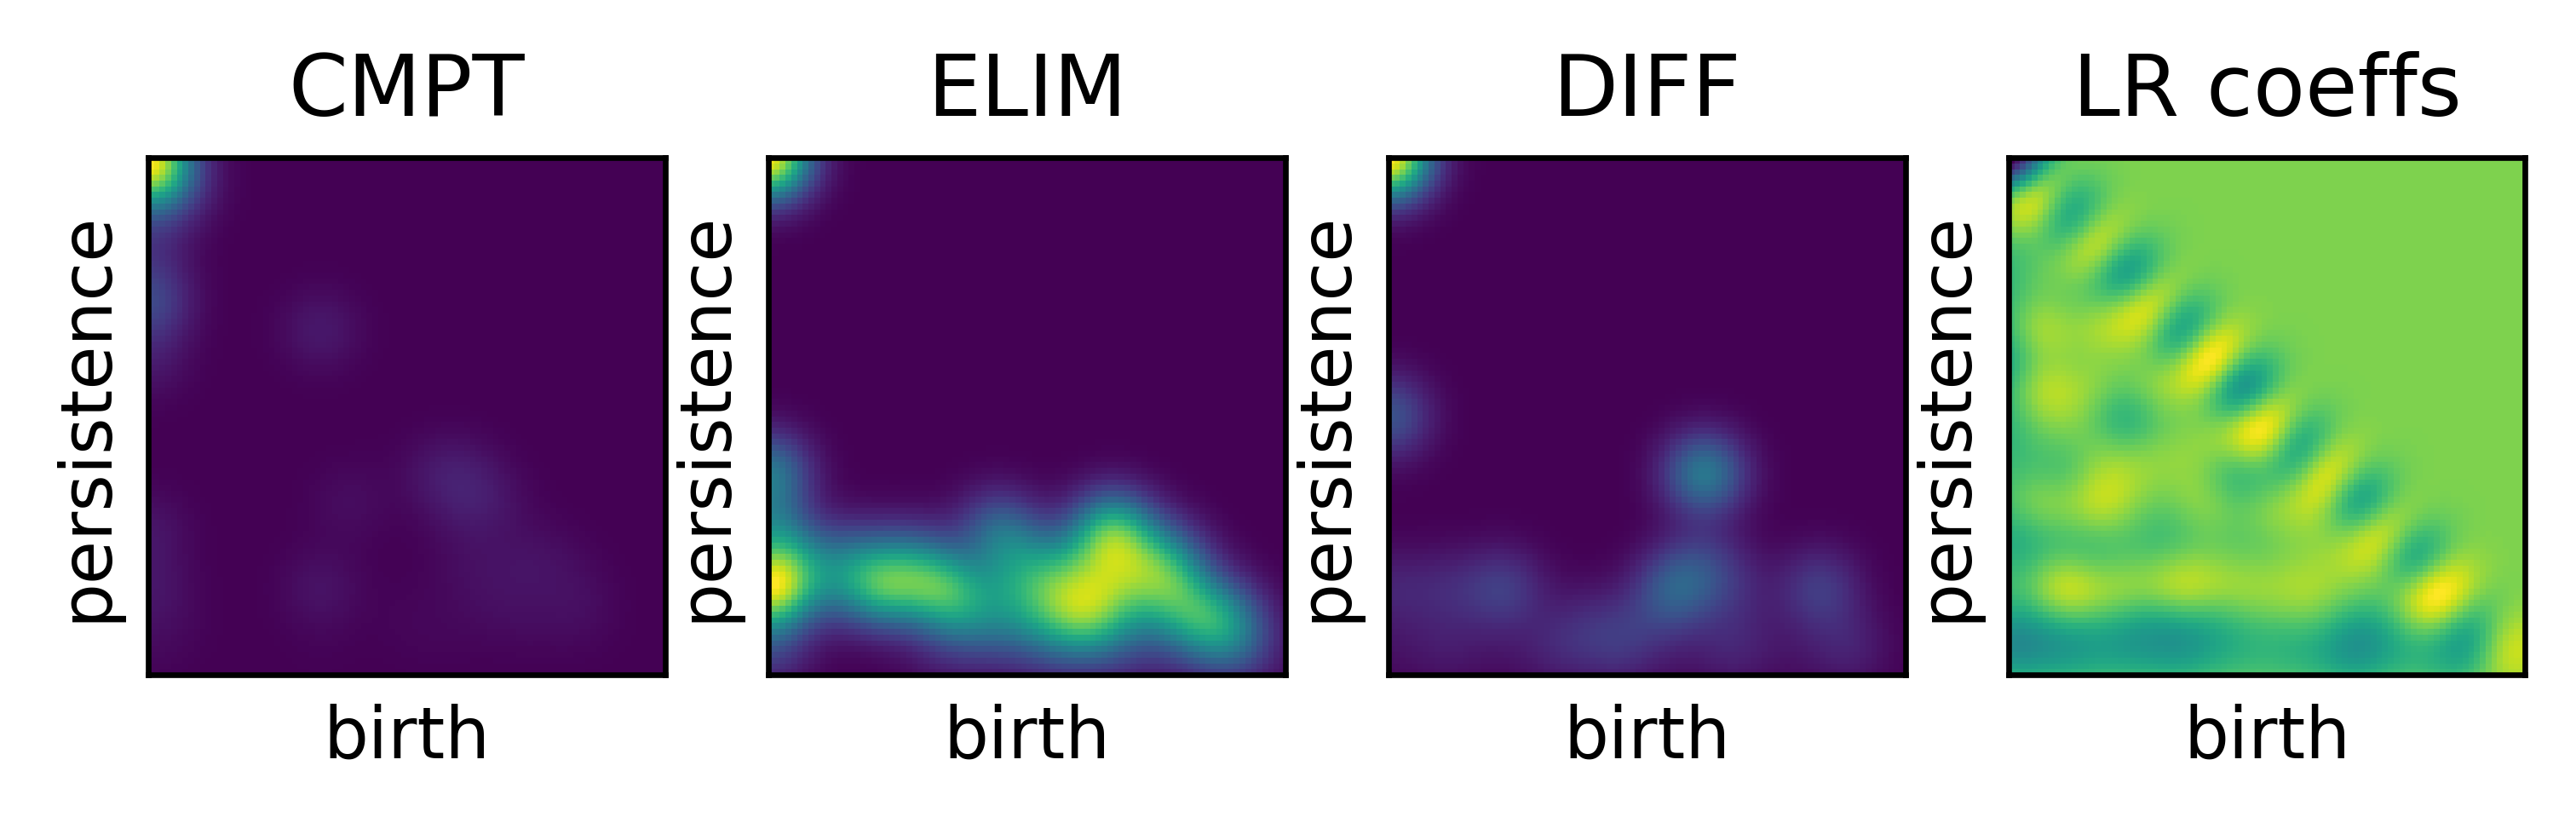

array([0.85521886, 0.89225589, 0.88888889, 0.87205387, 0.83838384,
       0.84175084, 0.87542088, 0.87878788, 0.87542088, 0.87878788,
       0.88888889, 0.84175084, 0.86868687, 0.83838384, 0.86195286,
       0.84848485, 0.84848485, 0.8989899 , 0.86531987, 0.86868687,
       0.84175084, 0.85858586, 0.88552189, 0.86868687, 0.89225589,
       0.88888889, 0.89225589, 0.86531987, 0.85858586, 0.82154882,
       0.88215488, 0.84848485, 0.86531987, 0.87205387, 0.87878788,
       0.87542088, 0.85521886, 0.87205387, 0.8956229 , 0.82491582,
       0.84175084, 0.87542088, 0.87542088, 0.85185185, 0.86868687,
       0.88552189, 0.86195286, 0.86531987, 0.86195286, 0.86195286])

In [13]:
diagrams_h0_zz = []
for i, ID in enumerate(tqdm.tqdm(params.id)):
    dgms = zigzag_dgms(ID, 'Macrophage', MU=3.5)
    diagrams_h0_zz.append( dgms )
    
pimgr_zz = PersistenceImager()
imgs_zz = pimgr_zz.fit_transform(diagrams_h0_zz)
imgs_array_zz = np.array([
    img.flatten()
    for img in imgs_zz
])
imgs['zz'] = imgs_zz

clf = LogisticRegression(max_iter=1000)
clf.fit(imgs_array_zz, labels)
print(clf.score(imgs_array_zz, labels))
inverse_image = np.copy(clf.coef_).reshape(pimgr_zz.resolution)

fig = plt.figure(dpi=600)

pimgr_zz.plot_image(imgs_zz[i0], fig.add_subplot(141)); plt.title("CMPT")
pimgr_zz.plot_image(imgs_zz[i1], fig.add_subplot(142)); plt.title("ELIM")
pimgr_zz.plot_image(imgs_zz[i2], fig.add_subplot(143)); plt.title("DIFF")
pimgr_zz.plot_image(inverse_image, fig.add_subplot(144)); plt.title("LR coeffs")
plt.show()

cv = RepeatedStratifiedKFold()
scores['zz'] = cross_val_score(clf, imgs_array_zz, labels, cv=cv)
scores['zz']


In [14]:
from sklearn.metrics import confusion_matrix

clf.fit(imgs_array_zz, labels)
y_pred = clf.predict(imgs_array_zz)
confusion_matrix(labels, y_pred)

array([[785, 112],
       [ 68, 520]])

In [15]:
98/475

0.2063157894736842

In [16]:
171/741

0.23076923076923078

100%|███████████████████████████████████████| 1485/1485 [04:21<00:00,  5.68it/s]


0.7299663299663299


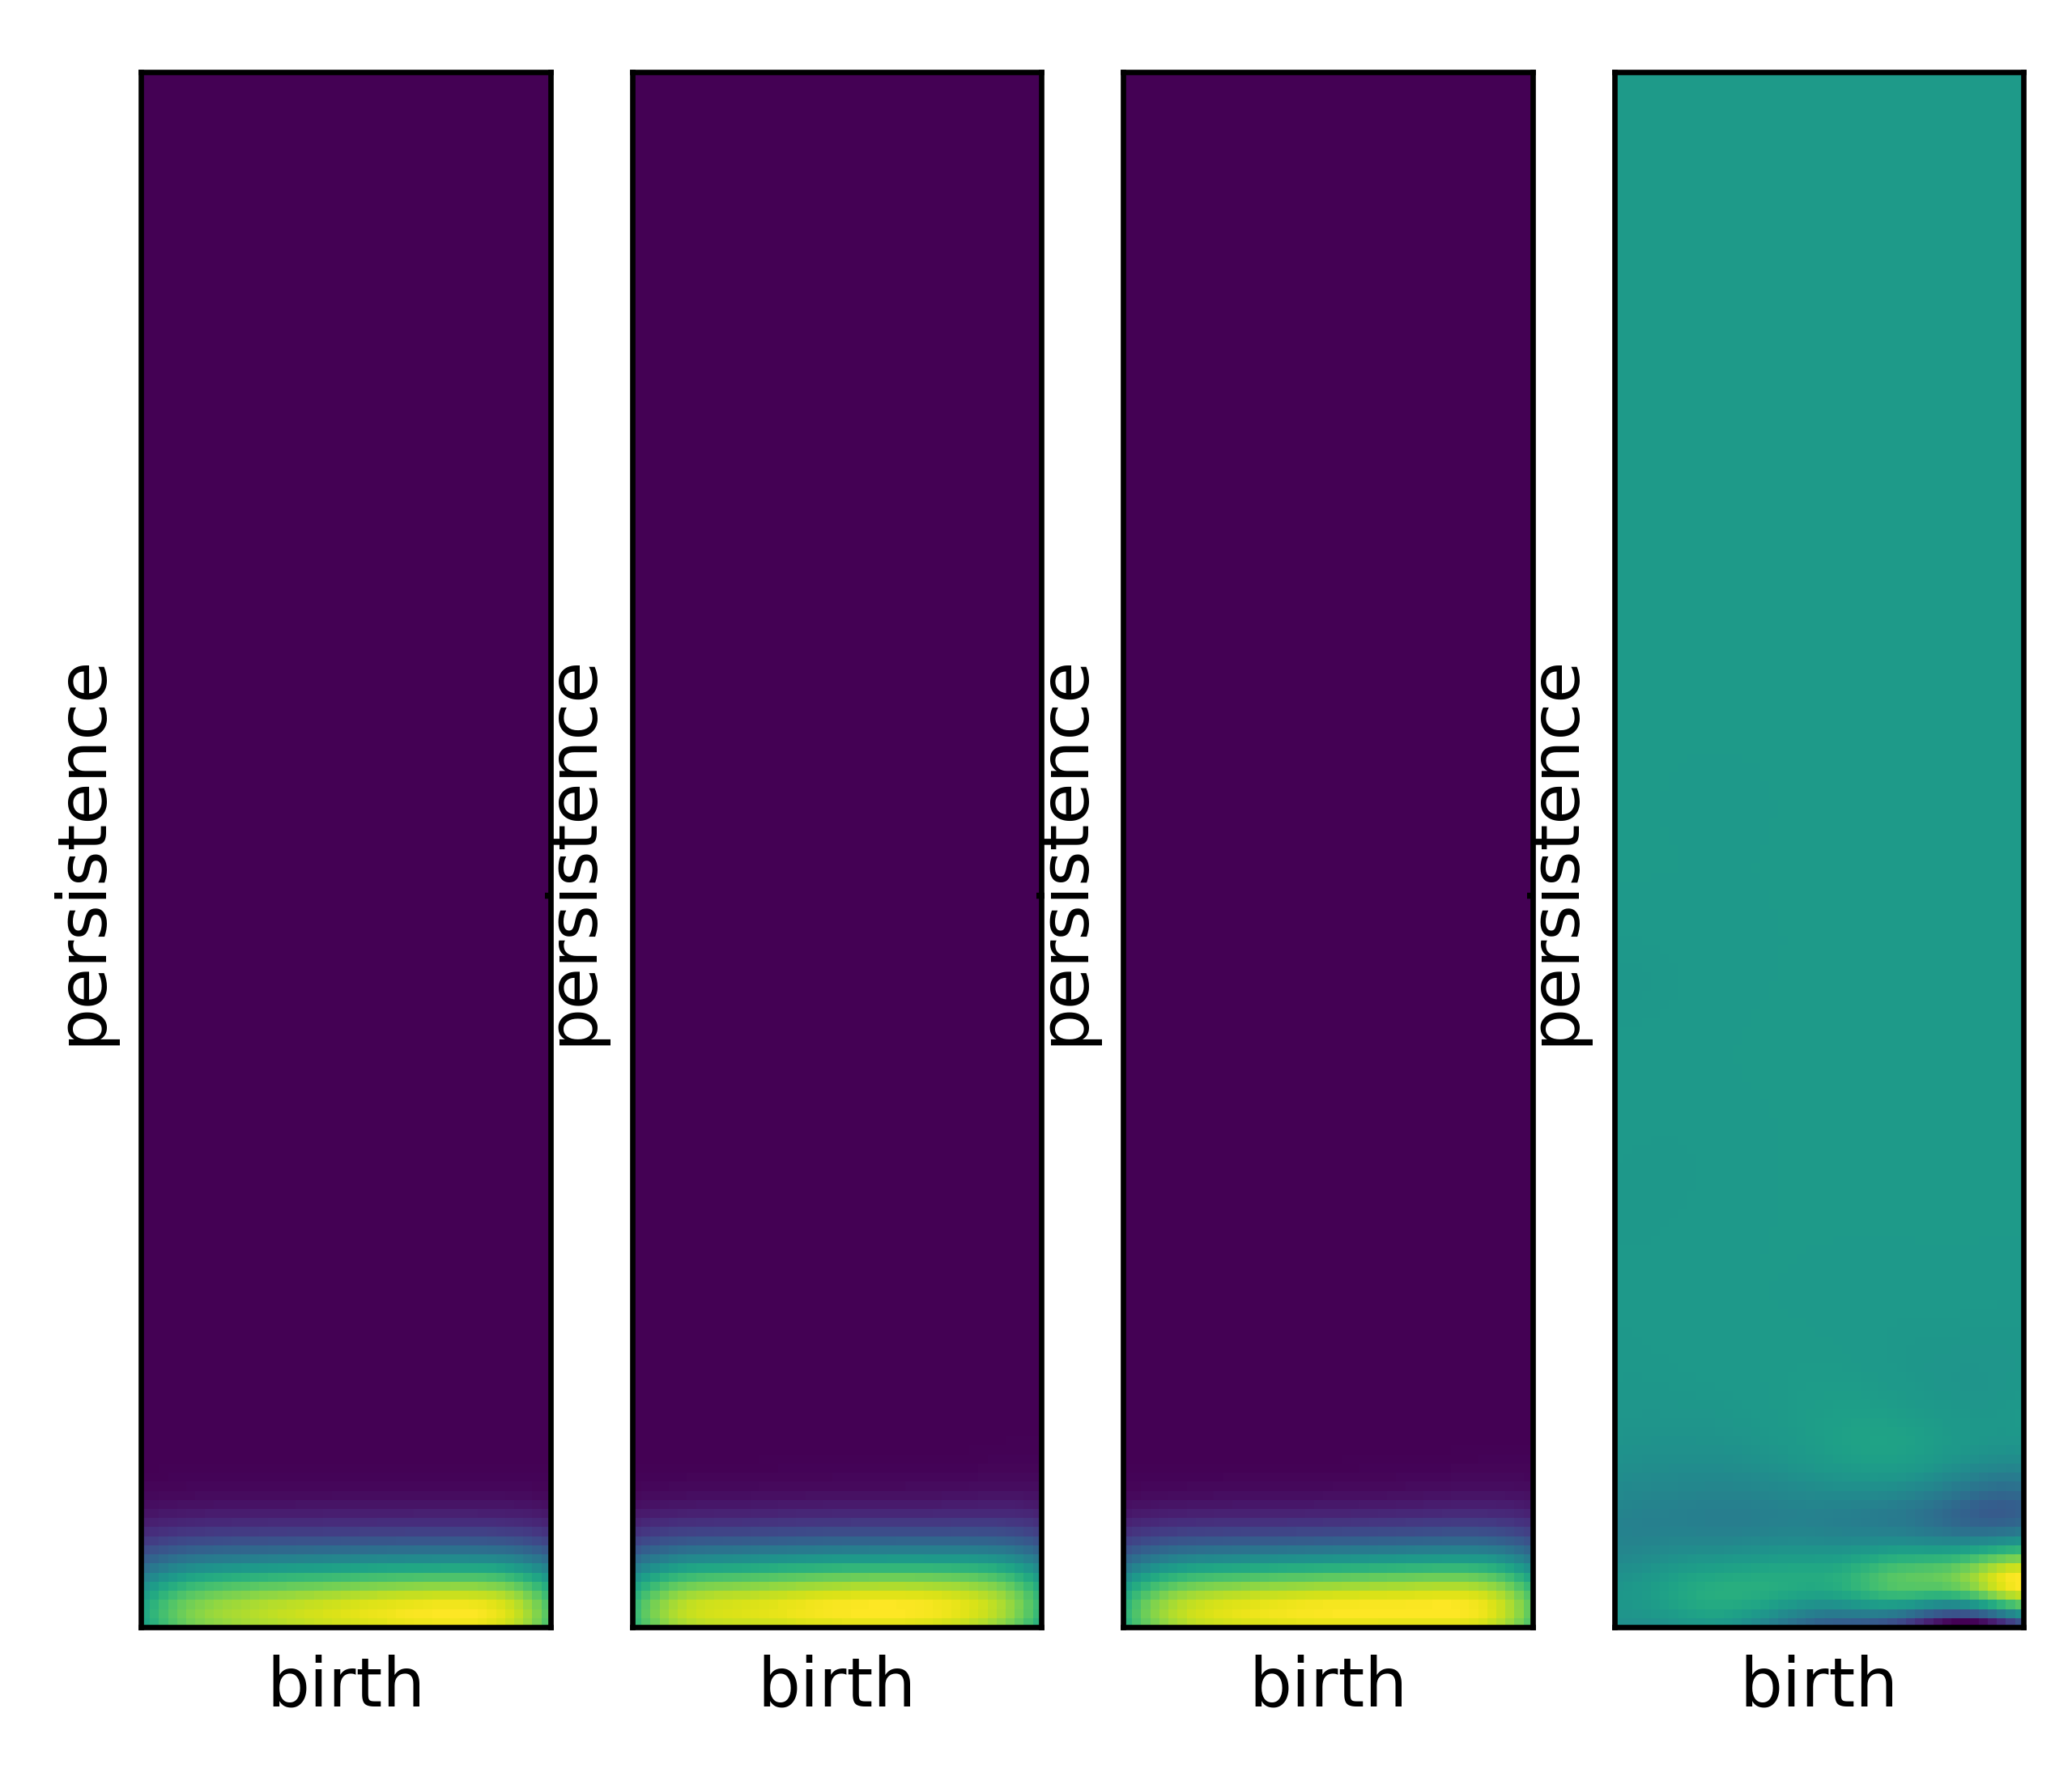

array([0.73400673, 0.71717172, 0.71717172, 0.68686869, 0.72390572,
       0.74074074, 0.74747475, 0.7037037 , 0.69360269, 0.68350168,
       0.69023569, 0.71717172, 0.70707071, 0.71717172, 0.72390572,
       0.71380471, 0.72727273, 0.74074074, 0.67676768, 0.71380471,
       0.7037037 , 0.6969697 , 0.7037037 , 0.72390572, 0.73737374,
       0.71717172, 0.74410774, 0.68686869, 0.69023569, 0.71717172,
       0.66329966, 0.74747475, 0.75757576, 0.72390572, 0.71043771,
       0.72053872, 0.7003367 , 0.6969697 , 0.7037037 , 0.76094276,
       0.72053872, 0.69360269, 0.72390572, 0.72390572, 0.69360269,
       0.71380471, 0.71717172, 0.72727273, 0.6969697 , 0.7003367 ])

In [17]:
diagrams_h0_rst = []
empty_idx = []
for i, ID in enumerate(tqdm.tqdm(params.id)):
    dgms = rips_dgms(ID, 'Tumour')
    if dgms.size == 0:
        empty_idx.append(i)
        dgms = np.array([ [0,1], [1,2] ])
    diagrams_h0_rst.append( dgms )
    
pimgr_rst = PersistenceImager()
imgs_rst = pimgr_rst.fit_transform(diagrams_h0_rst, skew=False)    
imgs_array_rst = np.array([
    img.flatten()
    for img in imgs_rst
])
for i in empty_idx:
    imgs_rst[i] = np.zeros(pimgr_rst.resolution)
    imgs_array_rst[i] = np.zeros(pimgr_rst.resolution).flatten()
imgs['rst'] = imgs_rst

clf = LogisticRegression(max_iter=1000)
clf.fit(imgs_array_rst, labels)
print(clf.score(imgs_array_rst, labels))
fig = plt.figure(dpi=600, figsize=(5,5))
inverse_image = np.copy(clf.coef_).reshape(pimgr_rst.resolution)
pimgr_rst.plot_image(imgs_rst[i0], fig.add_subplot(141))
pimgr_rst.plot_image(imgs_rst[i1], fig.add_subplot(142))
pimgr_rst.plot_image(imgs_rst[i2], fig.add_subplot(143))
pimgr_rst.plot_image(inverse_image, fig.add_subplot(144))
plt.show()

cv = RepeatedStratifiedKFold()
scores['rst'] = cross_val_score(clf, imgs_array_rst, labels, cv=cv)
scores['rst']

100%|███████████████████████████████████████| 1485/1485 [02:54<00:00,  8.50it/s]


0.9023569023569024


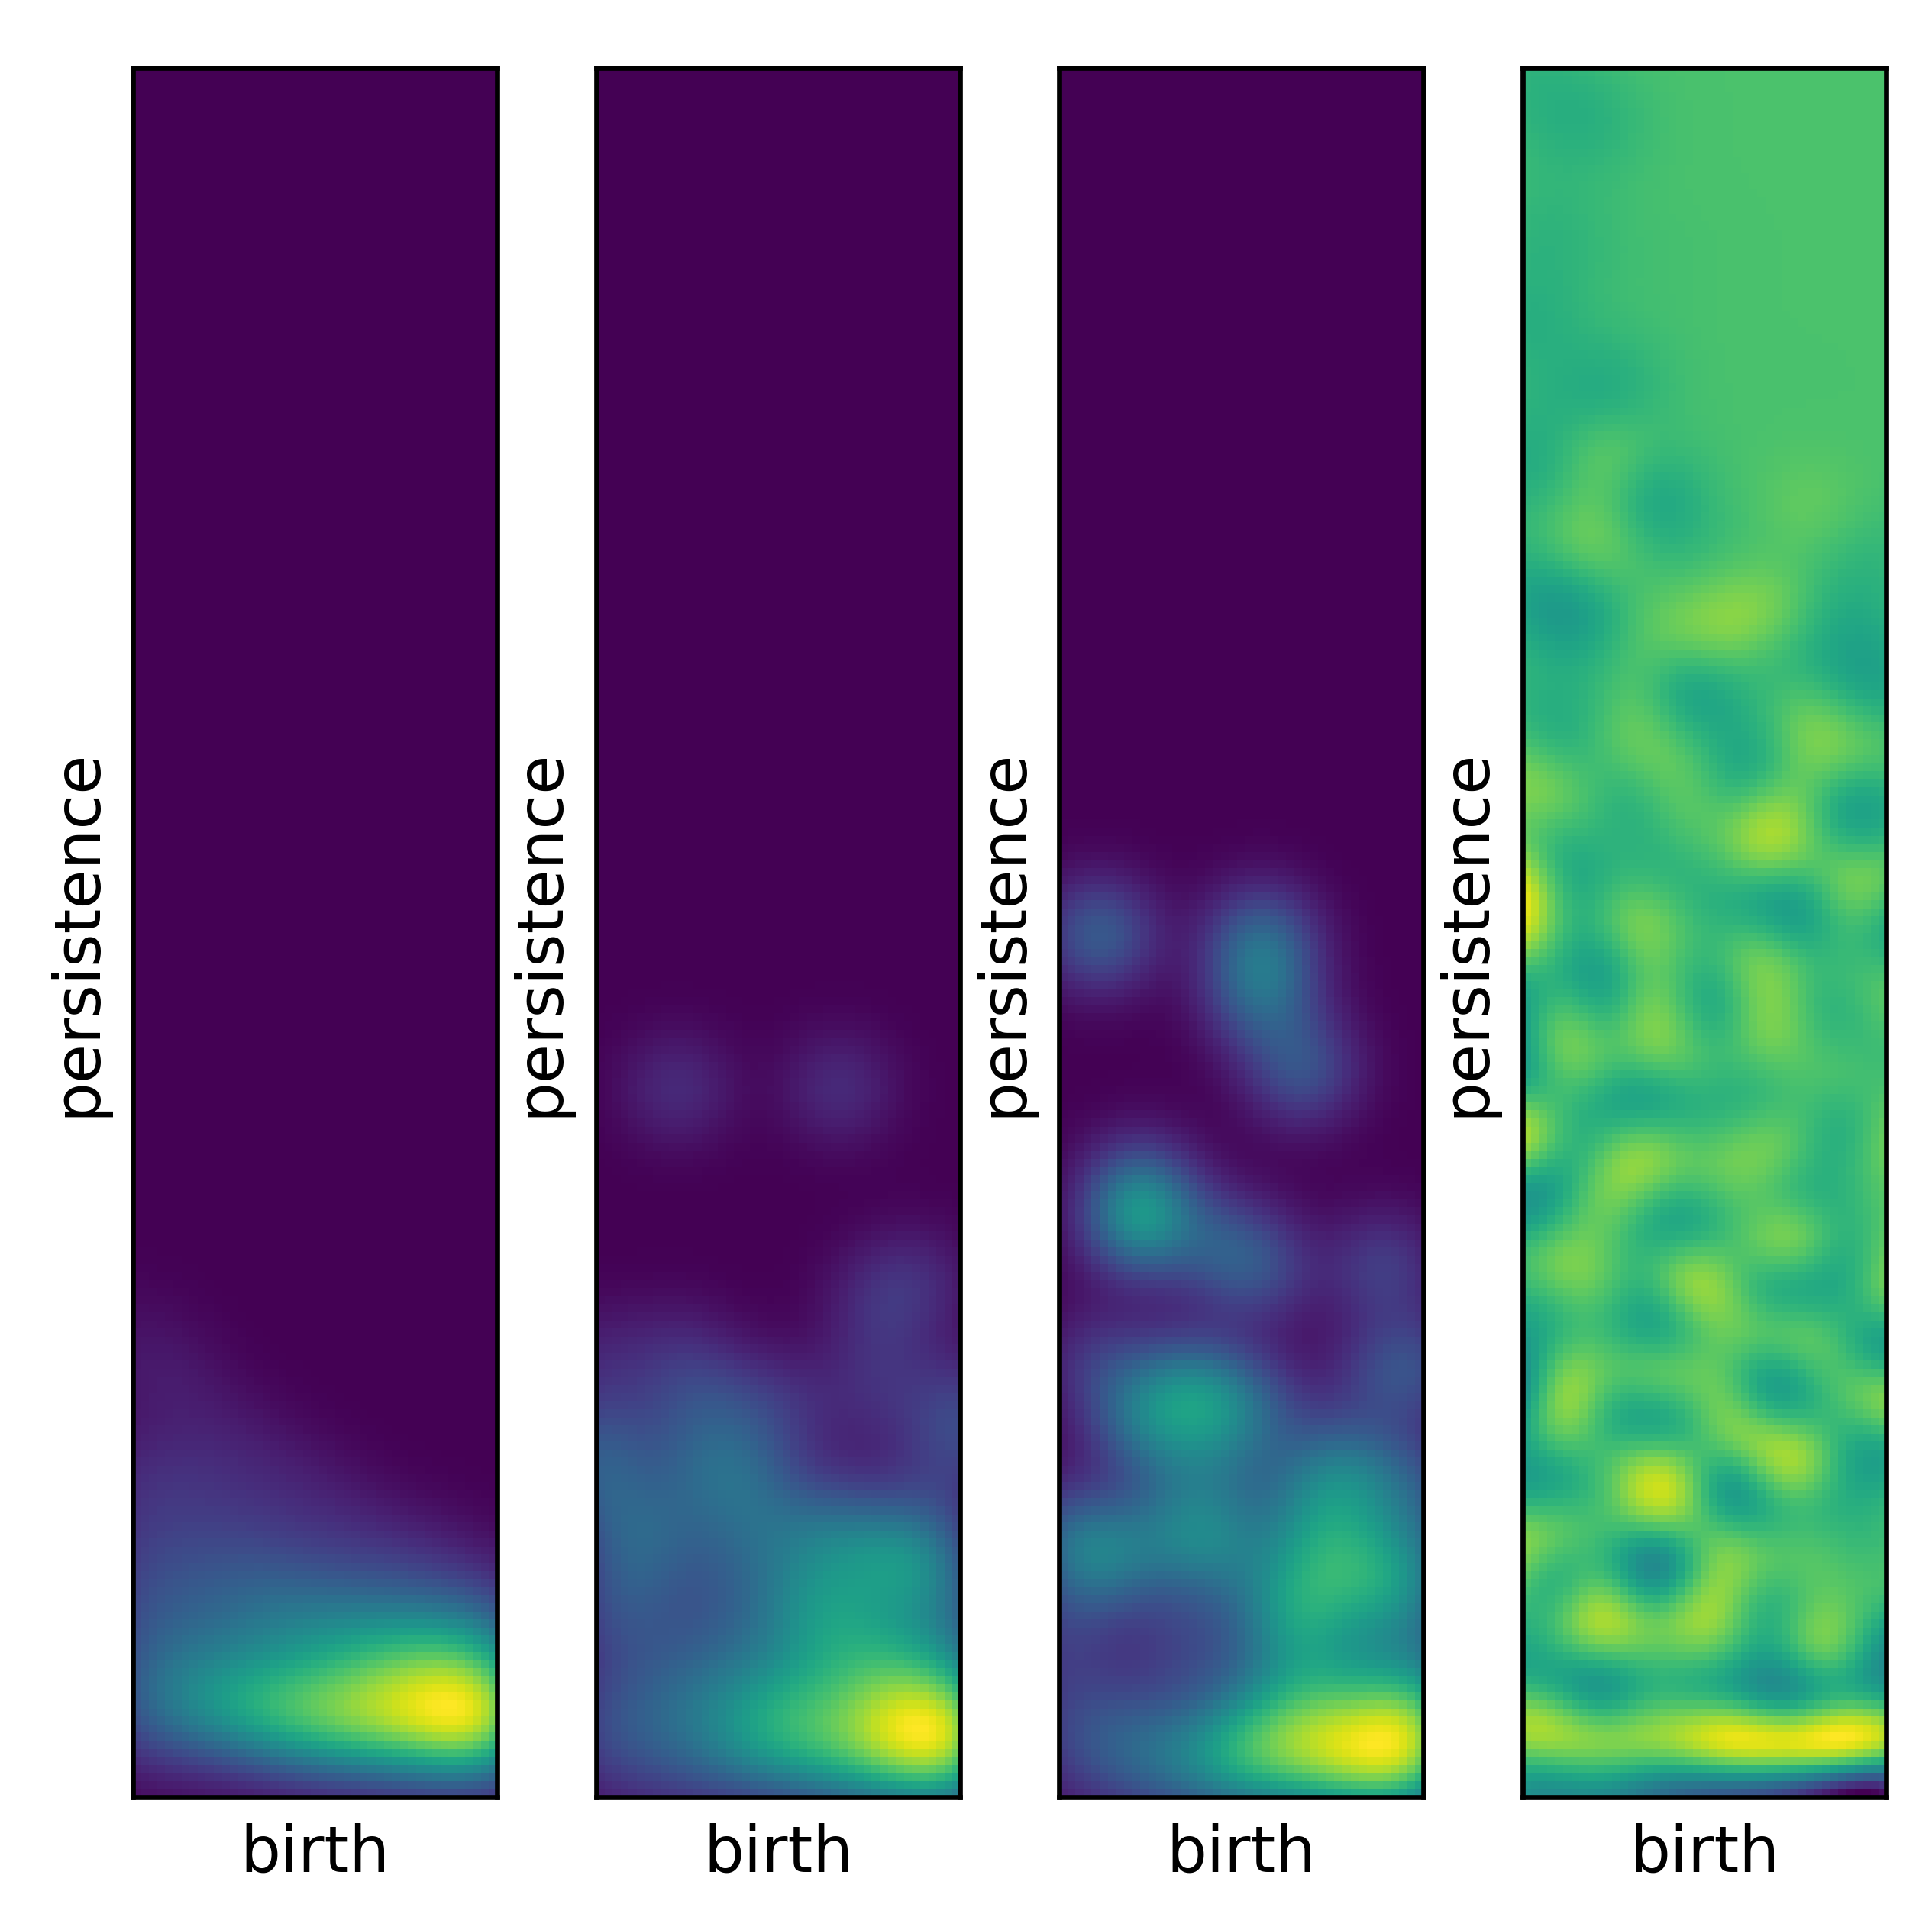

array([0.87542088, 0.85521886, 0.86195286, 0.87205387, 0.86195286,
       0.84848485, 0.87542088, 0.84175084, 0.84175084, 0.91919192,
       0.85858586, 0.87878788, 0.83164983, 0.87542088, 0.85858586,
       0.84848485, 0.87878788, 0.83838384, 0.88888889, 0.87878788,
       0.87205387, 0.86531987, 0.87205387, 0.83838384, 0.88552189,
       0.85858586, 0.87205387, 0.88888889, 0.83838384, 0.87542088,
       0.87542088, 0.87542088, 0.86531987, 0.87205387, 0.85858586,
       0.9023569 , 0.84848485, 0.84848485, 0.83838384, 0.87878788,
       0.87542088, 0.85185185, 0.86868687, 0.86195286, 0.86868687,
       0.86195286, 0.89225589, 0.86195286, 0.85185185, 0.87542088])

In [18]:
diagrams_h0_rs = []
for ID in tqdm.tqdm(params.id):
    diagrams_h0_rs.append( rips_dgms(ID, 'Macrophage') )
    
pimgr_rs = PersistenceImager()
imgs_rs = pimgr_rs.fit_transform(diagrams_h0_rs, skew=False)    
imgs_array_rs = np.array([
    img.flatten()
    for img in imgs_rs
])
imgs['rs'] = imgs_rs

clf = LogisticRegression(max_iter=1000)
clf.fit(imgs_array_rs, labels)
print(clf.score(imgs_array_rs, labels))
fig = plt.figure(dpi=600, figsize=(5,5))
inverse_image = np.copy(clf.coef_).reshape(pimgr_rs.resolution)
pimgr_rs.plot_image(imgs_rs[i0], fig.add_subplot(141))
pimgr_rs.plot_image(imgs_rs[i1], fig.add_subplot(142))
pimgr_rs.plot_image(imgs_rs[i2], fig.add_subplot(143))
pimgr_rs.plot_image(inverse_image, fig.add_subplot(144))
plt.show()

cv = RepeatedStratifiedKFold()
scores['rs'] = cross_val_score(clf, imgs_array_rs, labels, cv=cv)
scores['rs']

100%|███████████████████████████████████████| 1485/1485 [02:47<00:00,  8.89it/s]


array([0.67676768, 0.68686869, 0.6969697 , 0.70707071, 0.68350168,
       0.67340067, 0.71043771, 0.69023569, 0.69023569, 0.7037037 ,
       0.68013468, 0.68686869, 0.70707071, 0.71380471, 0.68350168,
       0.7037037 , 0.67003367, 0.67003367, 0.72390572, 0.68013468,
       0.70707071, 0.69360269, 0.69023569, 0.70707071, 0.66666667,
       0.71380471, 0.71380471, 0.67340067, 0.68686869, 0.69023569,
       0.68013468, 0.71043771, 0.68350168, 0.7037037 , 0.67676768,
       0.68013468, 0.68350168, 0.6969697 , 0.71043771, 0.7037037 ,
       0.69360269, 0.7037037 , 0.68686869, 0.66329966, 0.7003367 ,
       0.72053872, 0.73400673, 0.66329966, 0.67340067, 0.68350168])

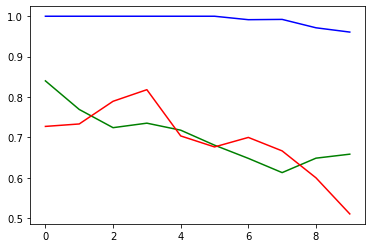

In [19]:
ratios = []
for ID in tqdm.tqdm(params.id):
    ratios.append( phenotype_ratio(ID) )

plt.plot(ratios[i0], 'b')
plt.plot(ratios[i1], 'g')
plt.plot(ratios[i2], 'r')

# # clf = SVC()
clf = LogisticRegression(max_iter=5000)
cv = RepeatedStratifiedKFold()
scores['phenotype'] = cross_val_score(clf, ratios, labels, cv=cv)
scores['phenotype']

100%|███████████████████████████████████████| 1485/1485 [02:45<00:00,  9.00it/s]


array([0.73400673, 0.74410774, 0.72053872, 0.71717172, 0.73400673,
       0.73063973, 0.75420875, 0.72390572, 0.76430976, 0.72390572,
       0.72053872, 0.74074074, 0.69023569, 0.78114478, 0.72390572,
       0.7037037 , 0.71380471, 0.72390572, 0.74410774, 0.75420875,
       0.72390572, 0.75420875, 0.78114478, 0.70707071, 0.71717172,
       0.75084175, 0.6969697 , 0.75084175, 0.78114478, 0.69360269,
       0.74074074, 0.72053872, 0.72390572, 0.76430976, 0.72390572,
       0.75420875, 0.71717172, 0.74074074, 0.73737374, 0.74410774,
       0.8013468 , 0.6969697 , 0.75420875, 0.69023569, 0.72053872,
       0.73400673, 0.75084175, 0.71043771, 0.73063973, 0.74747475])

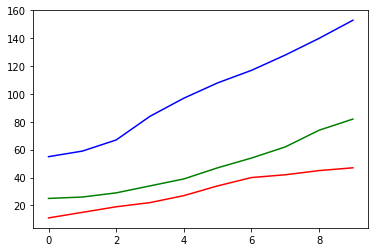

In [20]:
counts = []
for ID in tqdm.tqdm(params.id):
    counts.append( cell_count(ID, 'Macrophage') )

plt.plot(counts[i0], 'b')
plt.plot(counts[i1], 'g')
plt.plot(counts[i2], 'r')

clf = LogisticRegression(max_iter=5000)
cv = RepeatedStratifiedKFold()
scores['cc'] = cross_val_score(clf, counts, labels, cv=cv)
scores['cc']

100%|███████████████████████████████████████| 1485/1485 [02:46<00:00,  8.93it/s]


array([0.47138047, 0.50505051, 0.46801347, 0.51515152, 0.46801347,
       0.44444444, 0.46801347, 0.48484848, 0.46801347, 0.53872054,
       0.52188552, 0.4983165 , 0.43097643, 0.46127946, 0.48821549,
       0.48484848, 0.47138047, 0.49158249, 0.51178451, 0.44107744,
       0.45791246, 0.46464646, 0.48484848, 0.52861953, 0.49494949,
       0.50841751, 0.4983165 , 0.47474747, 0.47811448, 0.45117845,
       0.50841751, 0.44107744, 0.4983165 , 0.48484848, 0.49158249,
       0.49158249, 0.48484848, 0.50505051, 0.48484848, 0.47138047,
       0.45454545, 0.51178451, 0.53198653, 0.44444444, 0.46801347,
       0.48484848, 0.52188552, 0.47811448, 0.48821549, 0.44444444])

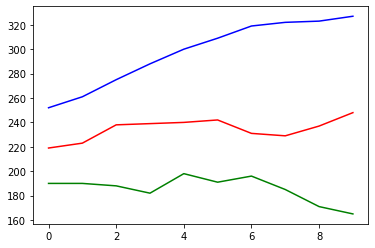

In [21]:
counts_t = []
for ID in tqdm.tqdm(params.id):
    counts_t.append( cell_count(ID, 'Tumour') )

plt.plot(counts_t[i0], 'b')
plt.plot(counts_t[i1], 'g')
plt.plot(counts_t[i2], 'r')

clf = LogisticRegression(max_iter=5000)
cv = RepeatedStratifiedKFold()
scores['cct'] = cross_val_score(clf, counts_t, labels, cv=cv)
scores['cct']

100%|███████████████████████████████████████| 1485/1485 [03:04<00:00,  8.04it/s]


array([0.5959596 , 0.5993266 , 0.59259259, 0.60606061, 0.60942761,
       0.58249158, 0.62962963, 0.60606061, 0.62626263, 0.57912458,
       0.56902357, 0.60606061, 0.62962963, 0.6026936 , 0.61952862,
       0.6026936 , 0.61279461, 0.5993266 , 0.58922559, 0.5959596 ,
       0.64309764, 0.5993266 , 0.58922559, 0.61952862, 0.56228956,
       0.61952862, 0.61616162, 0.5993266 , 0.56902357, 0.61279461,
       0.61279461, 0.6026936 , 0.61279461, 0.60942761, 0.57575758,
       0.57239057, 0.6026936 , 0.61279461, 0.5959596 , 0.62962963,
       0.61952862, 0.63299663, 0.58585859, 0.57239057, 0.58922559,
       0.5959596 , 0.58585859, 0.62962963, 0.5993266 , 0.58922559])

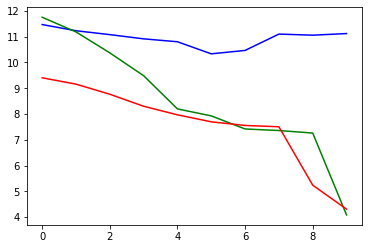

In [22]:
dists_t = []
for ID in tqdm.tqdm(params.id):
    dists_t.append( vessel_proximity(ID, 'Tumour') )

plt.plot(dists_t[i0], 'b')
plt.plot(dists_t[i1], 'g')
plt.plot(dists_t[i2], 'r')

clf = LogisticRegression(max_iter=5000)
cv = RepeatedStratifiedKFold()
scores['dt'] = cross_val_score(clf, dists_t, labels, cv=cv)
scores['dt']

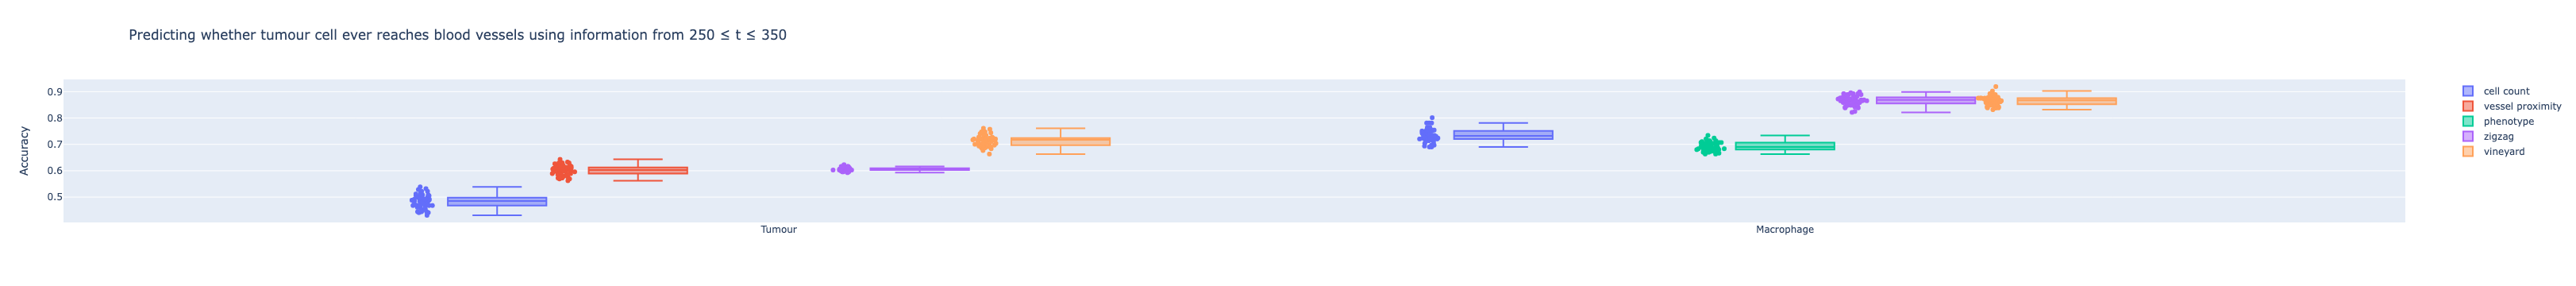

In [33]:
fig = go.Figure()
array = np.array

fig.add_trace(go.Box(
    x = ['Tumour']*50 + ['Macrophage']*50,
    y = np.r_[scores['cct'], scores['cc']],
    name='cell count',
))

fig.add_trace(go.Box(
    x = ['Tumour']*50,
    y = scores['dt'],
    name='vessel proximity',
))

fig.add_trace(go.Box(
    x = ['Macrophage']*50,
    y = scores['phenotype'],
    name='phenotype',
))

fig.add_trace(go.Box(
    x = ['Tumour']*50 + ['Macrophage']*50,
    y = np.r_[scores['zzt'], scores['zz']],
    name='zigzag',
))

fig.add_trace(go.Box(
    x = ['Tumour']*50 + ['Macrophage']*50,
    y = np.r_[scores['rst'], scores['rs']],
    name='vineyard',
))

fig.update_traces(
    boxpoints='all',
)

fig.update_layout(
    title = 'Predicting whether tumour cell ever reaches blood vessels using information from 250 ≤ t ≤ 350',
    yaxis_title='Accuracy',
    boxmode='group'
)
fig.show()

--- 0.0


100%|███████████████████████████████████████| 1485/1485 [03:19<00:00,  7.43it/s]


0.7333333333333333
0.7276094276094276
--- 0.5


100%|███████████████████████████████████████| 1485/1485 [03:22<00:00,  7.35it/s]


0.7851851851851852
0.7660606060606062
--- 1.0


100%|███████████████████████████████████████| 1485/1485 [03:40<00:00,  6.73it/s]


0.87003367003367
0.8498316498316498
--- 1.5


100%|███████████████████████████████████████| 1485/1485 [03:35<00:00,  6.90it/s]


0.8983164983164983
0.8798653198653197
--- 2.0


100%|███████████████████████████████████████| 1485/1485 [03:28<00:00,  7.11it/s]


0.9003367003367003
0.8833670033670034
--- 2.5


100%|███████████████████████████████████████| 1485/1485 [03:18<00:00,  7.48it/s]


0.901010101010101
0.8814814814814814
--- 3.0


100%|███████████████████████████████████████| 1485/1485 [03:16<00:00,  7.58it/s]


0.8909090909090909
0.8751515151515151
--- 3.5


100%|███████████████████████████████████████| 1485/1485 [03:17<00:00,  7.53it/s]


0.8787878787878788
0.8627609427609428
--- 4.0


100%|███████████████████████████████████████| 1485/1485 [03:18<00:00,  7.48it/s]


0.8686868686868687
0.8484175084175085
--- 4.5


100%|███████████████████████████████████████| 1485/1485 [03:18<00:00,  7.47it/s]


0.8585858585858586
0.8449158249158251
--- 5.0


100%|███████████████████████████████████████| 1485/1485 [03:19<00:00,  7.44it/s]


0.8471380471380472
0.8288215488215489


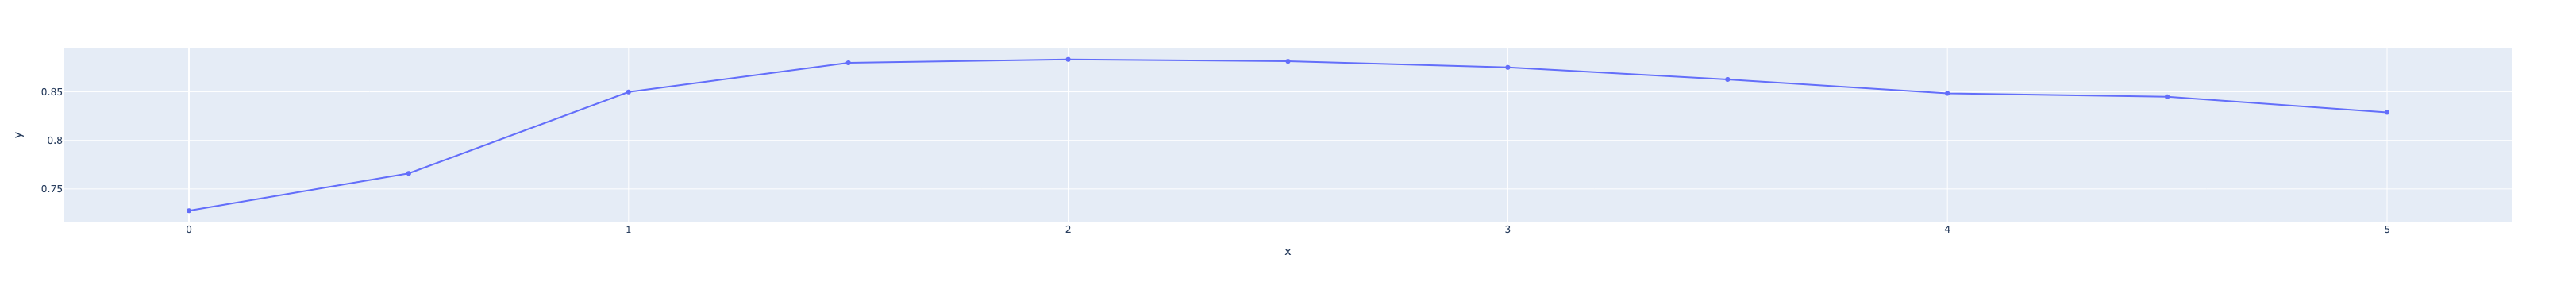

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

In [24]:
l_mu = np.linspace(0,5,11)
l_score = []

for mu in np.linspace(0, 5, 11):
    print('---', mu)

    diagrams_h0_zz = []
    for i, ID in enumerate(tqdm.tqdm(params.id)):
        dgms = zigzag_dgms(ID, 'Macrophage', MU=mu)
        diagrams_h0_zz.append( dgms )

    pimgr_zz = PersistenceImager()
    imgs_zz = pimgr_zz.fit_transform(diagrams_h0_zz)
    imgs_array_zz = np.array([
        img.flatten()
        for img in imgs_zz
    ])
    imgs['zz'] = imgs_zz

    clf = LogisticRegression(max_iter=1000)
    clf.fit(imgs_array_zz, labels)
    inverse_image = np.copy(clf.coef_).reshape(pimgr_zz.resolution)
    print(clf.score(imgs_array_zz, labels))

    cv = RepeatedStratifiedKFold()
    score = cross_val_score(clf, imgs_array_zz, labels, cv=cv).mean()
    print(score); l_score.append(score)

    fig = plt.figure(dpi=600)
    # pimgr_zz.plot_image(imgs_zz[i0], fig.add_subplot(141))
    # pimgr_zz.plot_image(imgs_zz[i1], fig.add_subplot(142))
    # pimgr_zz.plot_image(imgs_zz[i2], fig.add_subplot(143))
    # pimgr_zz.plot_image(inverse_image, fig.add_subplot(144))
    # plt.show()

px.line([], x=l_mu, y=l_score, markers=True)

100%|███████████████████████████████████████| 1485/1485 [02:51<00:00,  8.65it/s]


array([0.60606061, 0.6026936 , 0.6026936 , 0.5993266 , 0.6026936 ,
       0.6026936 , 0.60606061, 0.5993266 , 0.6026936 , 0.5993266 ,
       0.5993266 , 0.6026936 , 0.6026936 , 0.6026936 , 0.6026936 ,
       0.5959596 , 0.60606061, 0.6026936 , 0.5959596 , 0.6026936 ,
       0.6026936 , 0.60606061, 0.6026936 , 0.5993266 , 0.6026936 ,
       0.60606061, 0.60606061, 0.59259259, 0.5993266 , 0.6026936 ,
       0.60606061, 0.6026936 , 0.6026936 , 0.6026936 , 0.5959596 ,
       0.5993266 , 0.60606061, 0.5959596 , 0.6026936 , 0.5959596 ,
       0.5959596 , 0.60606061, 0.5993266 , 0.6026936 , 0.5959596 ,
       0.60606061, 0.60606061, 0.5959596 , 0.5959596 , 0.5993266 ])

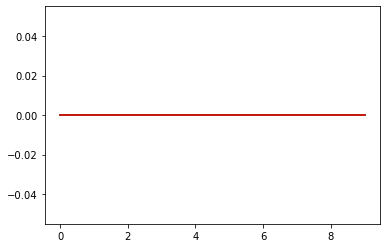

In [26]:
counts = []
for ID in tqdm.tqdm(params.id):
    counts.append( cell_count_close(ID, 'Tumour', r=2) )

plt.plot(counts[i0], 'b')
plt.plot(counts[i1], 'g')
plt.plot(counts[i2], 'r')

clf = LogisticRegression(max_iter=5000)
cv = RepeatedStratifiedKFold()
scores['ccc'] = cross_val_score(clf, counts, labels, cv=cv)
scores['ccc']

100%|███████████████████████████████████████| 1485/1485 [02:50<00:00,  8.69it/s]


array([0.80808081, 0.81818182, 0.83164983, 0.80808081, 0.83838384,
       0.83838384, 0.83838384, 0.78114478, 0.81481481, 0.82154882,
       0.82154882, 0.77104377, 0.86531987, 0.7979798 , 0.81818182,
       0.81144781, 0.83164983, 0.80808081, 0.82491582, 0.8013468 ,
       0.79124579, 0.82828283, 0.84175084, 0.82154882, 0.81144781,
       0.8047138 , 0.81818182, 0.81481481, 0.82828283, 0.82828283,
       0.82491582, 0.82491582, 0.78451178, 0.8047138 , 0.85858586,
       0.78787879, 0.8047138 , 0.79124579, 0.87878788, 0.82828283,
       0.8047138 , 0.80808081, 0.83501684, 0.84175084, 0.81818182,
       0.82828283, 0.81481481, 0.83501684, 0.83501684, 0.79461279])

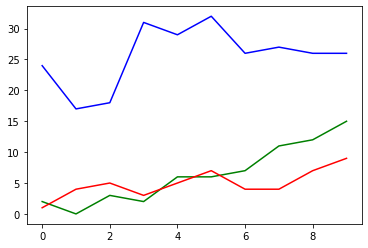

In [27]:
counts = []
for ID in tqdm.tqdm(params.id):
    counts.append( cell_count_close(ID, 'Macrophage', r=2) )

plt.plot(counts[i0], 'b')
plt.plot(counts[i1], 'g')
plt.plot(counts[i2], 'r')

clf = LogisticRegression(max_iter=5000)
cv = RepeatedStratifiedKFold()
scores['ccct'] = cross_val_score(clf, counts, labels, cv=cv)
scores['ccct']

In [28]:
scores_p = []
times = list(range(25, 50+1, 1))

for t in tqdm.tqdm(times):
    rs = []
    for ID in params.id:
        df = pd.read_csv(f'data/ID-{ID}_time-{t*10}_From2ParamSweep_Data.csv')
        p = df[df.celltypes == 'Macrophage'].phenotypes
        rs.append([ len(p[p < .5]) / len(p) ])
    rs = np.array(rs)
    
    clf = LogisticRegression(max_iter=5000)
    cv = RepeatedStratifiedKFold()
    scores_p.append( cross_val_score(clf, rs, labels, cv=cv) )
scores_p = np.array(scores_p)

100%|███████████████████████████████████████████| 26/26 [02:51<00:00,  6.61s/it]


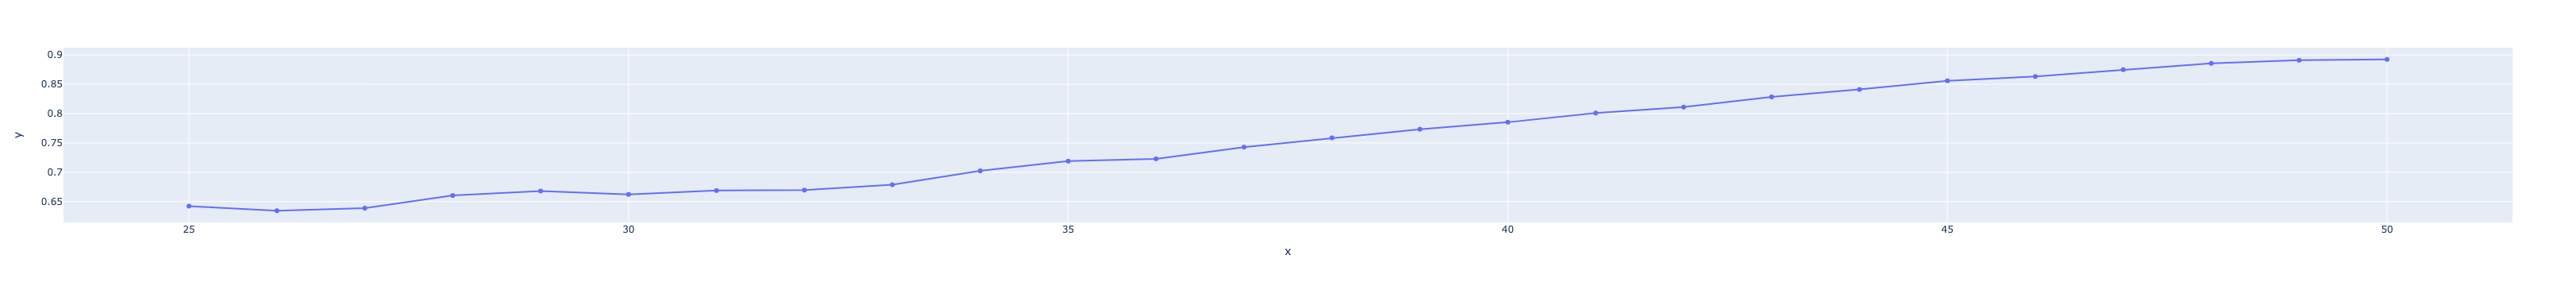

In [29]:
px.line([], x=times, y=scores_p.mean(axis=1), markers=True)

In [30]:
scores_d = []
times = list(range(25, 50+1, 1))

for t in tqdm.tqdm(times):
    rs = []
    for ID in params.id:
        df = pd.read_csv(f'data/ID-{ID}_time-{t*10}_From2ParamSweep_Data.csv')
        p = df[df.celltypes == 'Macrophage'].phenotypes
        rs.append([ len(p[p < .5]) / len(p) ])
    rs = np.array(rs)
    
    clf = LogisticRegression(max_iter=5000)
    cv = RepeatedStratifiedKFold()
    scores_d.append( cross_val_score(clf, rs, labels, cv=cv) )
scores_d = np.array(scores_p)

array([0.64222222, 0.63434343, 0.6386532 , 0.66026936, 0.66801347,
       0.66222222, 0.66875421, 0.66949495, 0.6786532 , 0.7023569 ,
       0.7189899 , 0.72289562, 0.74282828, 0.75858586, 0.77333333,
       0.78525253, 0.80094276, 0.81104377, 0.82848485, 0.84114478,
       0.8559596 , 0.86323232, 0.87494949, 0.88565657, 0.89097643,
       0.89245791])

100%|███████████████████████████████████████| 20/20 [7:07:05<00:00, 1281.27s/it]


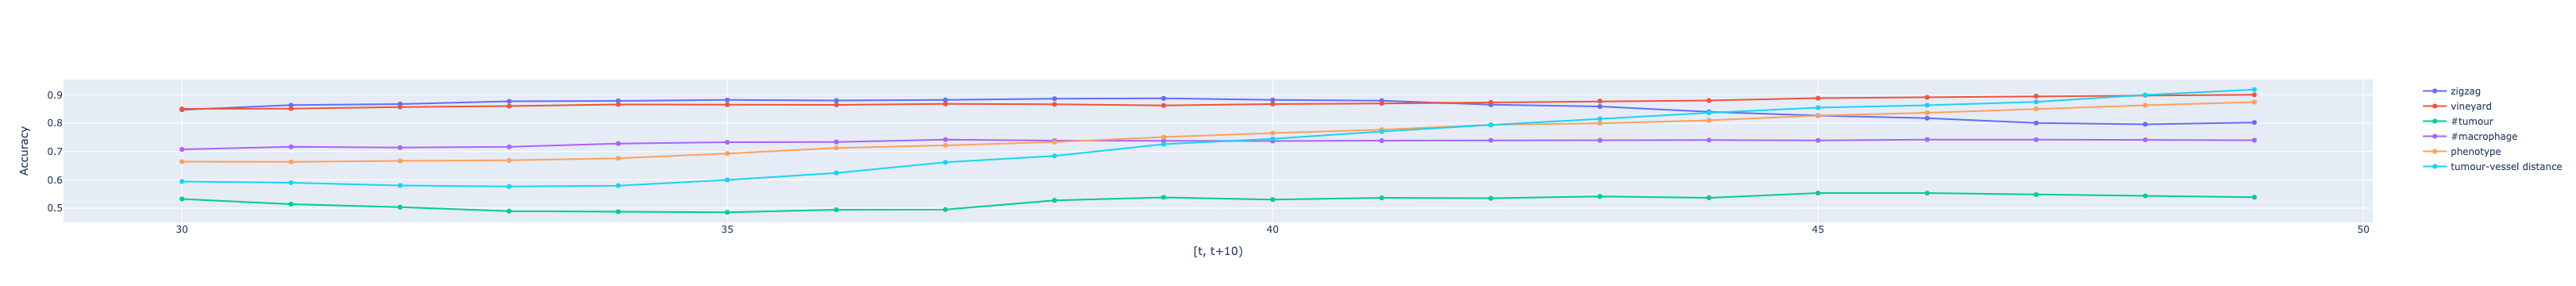

In [29]:
scores_t = {'zigzag': [], 'vineyard': [], '#tumour': [], '#macrophage': [], 'phenotype': [], 'tumour-vessel distance': []}
times = list(range(30, 50))

for END in tqdm.tqdm(times):
    START = END - 10

    
    diagrams_h0_zz = []
    for ID in params.id:
        dgms = zigzag_dgms(ID, 'Macrophage', MU=2)
        diagrams_h0_zz.append( dgms )

    pimgr_zz = PersistenceImager()
    imgs_zz = pimgr_zz.fit_transform(diagrams_h0_zz)
    imgs_array_zz = np.array([
        img.flatten()
        for img in imgs_zz
    ])

    clf = LogisticRegression(max_iter=1000)
    cv = RepeatedStratifiedKFold()
    scores_t['zigzag'].append( cross_val_score(clf, imgs_array_zz, labels, cv=cv) )
    
    
    
    diagrams_h0_rs = []
    for ID in params.id:
        diagrams_h0_rs.append( rips_dgms(ID, 'Macrophage') )

    pimgr_rs = PersistenceImager()
    imgs_rs = pimgr_rs.fit_transform(diagrams_h0_rs, skew=False)    
    imgs_array_rs = np.array([
        img.flatten()
        for img in imgs_rs
    ])

    clf = LogisticRegression(max_iter=1000)
    cv = RepeatedStratifiedKFold()
    scores_t['vineyard'].append( cross_val_score(clf, imgs_array_rs, labels, cv=cv) )
    
    
    
    counts = []
    for ID in params.id:
        counts.append( cell_count(ID, 'Tumour') )
    clf = LogisticRegression(max_iter=5000)
    cv = RepeatedStratifiedKFold()
    scores_t['#tumour'].append( cross_val_score(clf, counts, labels, cv=cv) )


    
    counts = []
    for ID in params.id:
        counts.append( cell_count(ID, 'Macrophage') )
    clf = LogisticRegression(max_iter=5000)
    cv = RepeatedStratifiedKFold()
    scores_t['#macrophage'].append( cross_val_score(clf, counts, labels, cv=cv) )
    

    
    ratios = []
    for ID in params.id:
        ratios.append( phenotype_ratio(ID) )
    clf = LogisticRegression(max_iter=5000)
    cv = RepeatedStratifiedKFold()
    scores_t['phenotype'].append( cross_val_score(clf, ratios, labels, cv=cv) )
    
    
    
    ds = []
    for ID in params.id:
        ds.append( vessel_proximity(ID, 'Tumour') )
    clf = LogisticRegression(max_iter=5000)
    cv = RepeatedStratifiedKFold()
    scores_t['tumour-vessel distance'].append( cross_val_score(clf, ds, labels, cv=cv) )



fig = go.Figure()
for name, ss in scores_t.items():
    fig.add_trace(go.Scatter(
        name=name,
        x=times,
        y=np.array(ss).mean(axis=1),
        mode='lines+markers',
    ))
fig.update_layout(
    yaxis_title='Accuracy',
    xaxis_title='[t, t+10)',
)
fig.show()

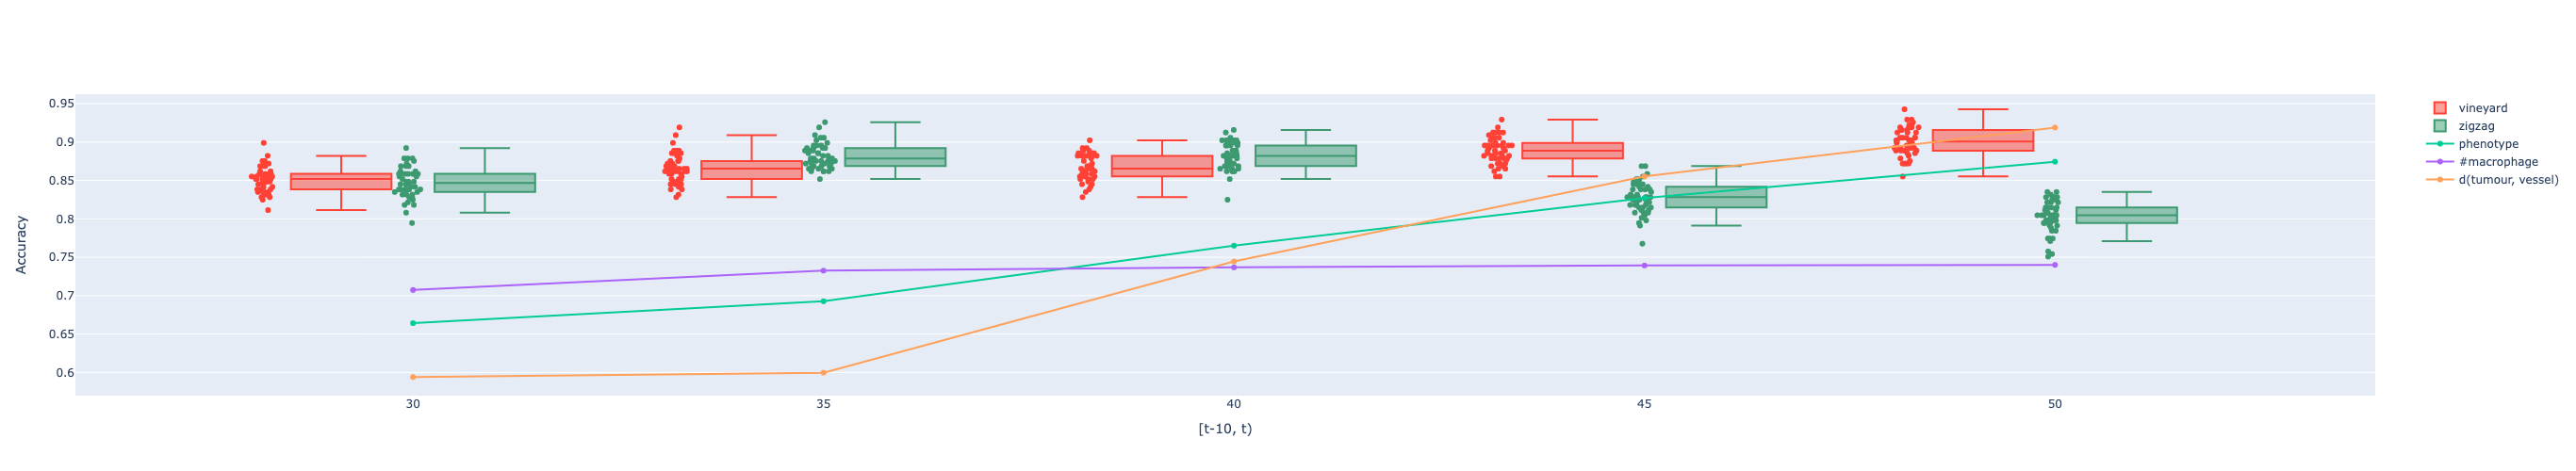

In [74]:
fig = go.Figure()

l_i = [0, 5, 10, 15, 19]
l_t = [30,35,40, 45, 50]

fig.add_trace(go.Box(
    y=[s for i in l_i for s in scores_t['vineyard'][i] ],
    x=[t for t in l_t for _ in range(50)],
    name='vineyard',
    marker_color='#FF4136'
))
fig.add_trace(go.Box(
    y=[s for i in l_i for s in scores_t['zigzag'][i] ],
    x=[t for t in l_t for _ in range(50)],
    name='zigzag',
    marker_color='#3D9970'
))
fig.update_traces(
    boxpoints="all",
)

# fig.add_trace(go.Scatter(
#     name='phenotype',
#     x=times,
#     y=np.array(scores_t['phenotype']).mean(axis=1),
#     mode='lines+markers',
# ))
fig.add_trace(go.Scatter(
    name='phenotype',
    x=l_t,
    y=np.array(scores_t['phenotype'])[l_i].mean(axis=1),
    mode='lines+markers',
))
fig.add_trace(go.Scatter(
    name='#macrophage',
    x=l_t,
    y=np.array(scores_t['#macrophage'])[l_i].mean(axis=1),
    mode='lines+markers',
))
# fig.add_trace(go.Scatter(
#     name='d(tumour, vessel)',
#     x=l_t,
#     y=np.array(scores_t['tumour-vessel distance'])[l_i].mean(axis=1),
#     mode='lines+markers',
# ))
# fig.add_trace(go.Scatter(
#     name='#tumour',
#     x=l_t,
#     y=np.array(scores_t['#tumour'])[l_i].mean(axis=1),
#     mode='lines+markers',
# ))


fig.update_layout(
    width=2_000,
    height=500,    
    yaxis_title='Accuracy',
    xaxis_title='[t-10, t)',
    boxmode='group',
)
fig.show()

<AxesSubplot:xlabel='birth', ylabel='death'>

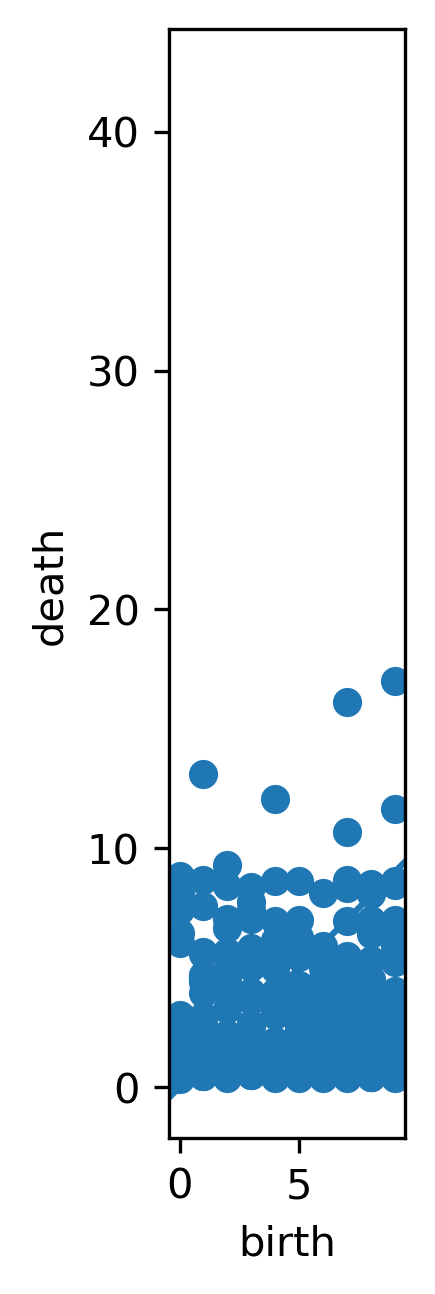

In [50]:
ax = plt.figure(dpi=300).add_subplot(111)
pimgr_rs.plot_diagram(diagrams_h0_rs[-1], ax=ax, skew=False)

<AxesSubplot:xlabel='birth', ylabel='persistence'>

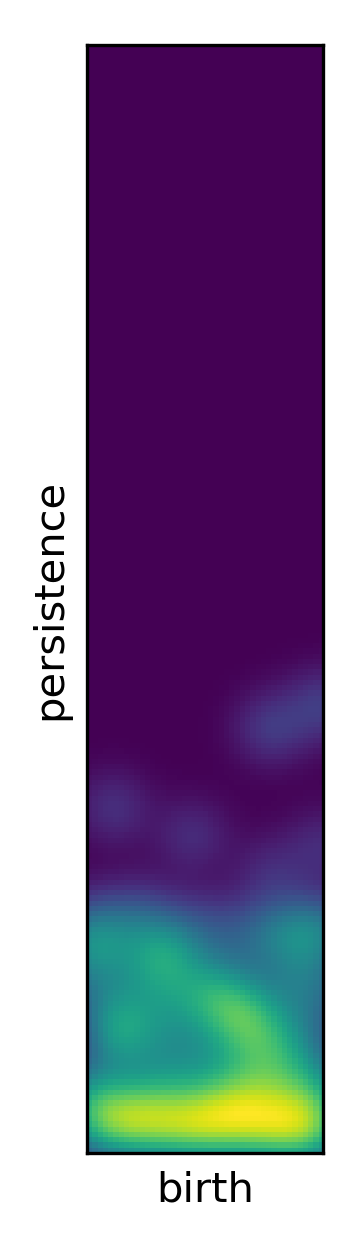

In [51]:
ax = plt.figure(dpi=300).add_subplot(111)
pimgr_rs.plot_image(imgs_rs[-1], ax=ax)